In [1]:
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
with open("post_process/processed_reviews_combined.json", "r") as f:
    documents = json.load(f)

In [3]:
# Convert token lists to space-separated strings for TfidfVectorizer as it expects string input, not lists of tokens
documents_str = [" ".join(doc) for doc in documents]

Example of values in documents_str:
```json
[
  [
    "plantronic",
    "headset",
    "husband",
    "headset",
    "choice",
    "time",
    "purchase",
    "year",
    "work",
    "cell",
    "iphone",
    "remember",
    "number",
    "headset",
    "come"
  ]
]
```
We have 1000 reviews, and each review is represented by a list of tokens. So we have 1000 lists of tokens, and we'll convert them into 1000 strings to pass them to TfidfVectorizer.

In [4]:
tfidf = TfidfVectorizer(min_df=20, max_df=0.95)
tfidf_matrix = tfidf.fit_transform(documents_str)

Note that here, we have already used the optimal parameters for better results. These parameters were determined in another notebook, and are as follows:
- `min_df=20`: we ignore words that appear in fewer than 20 documents. This helps reduce noise in the data.
- `max_df=0.95`: we ignore words that appear in more than 95% of documents. This helps reduce very frequent words that are not very informative.

In [5]:
# Elbow method
inertias = []
K = range(1, 11)

In [6]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)

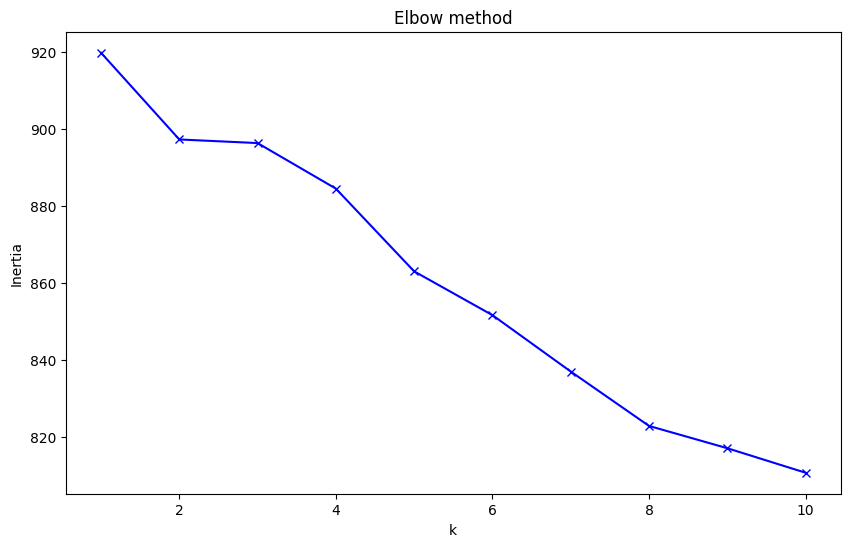

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()

We can see that the elbow curve starts to flatten at k=2, or around k=8. This means that the optimal number of clusters is probably one of these two values. However, the curve doesn't really show a clear “elbow”, so there may be some subjectivity in choosing the optimal number of clusters. Instead, we'll try to choose a number of clusters based on the silhouette score.

In [8]:
from sklearn.metrics import silhouette_score

In [9]:
silhouette_scores = []
K = range(2, 11)  # We'll start with 2 since silhouette score requires at least 2 clusters

In [10]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

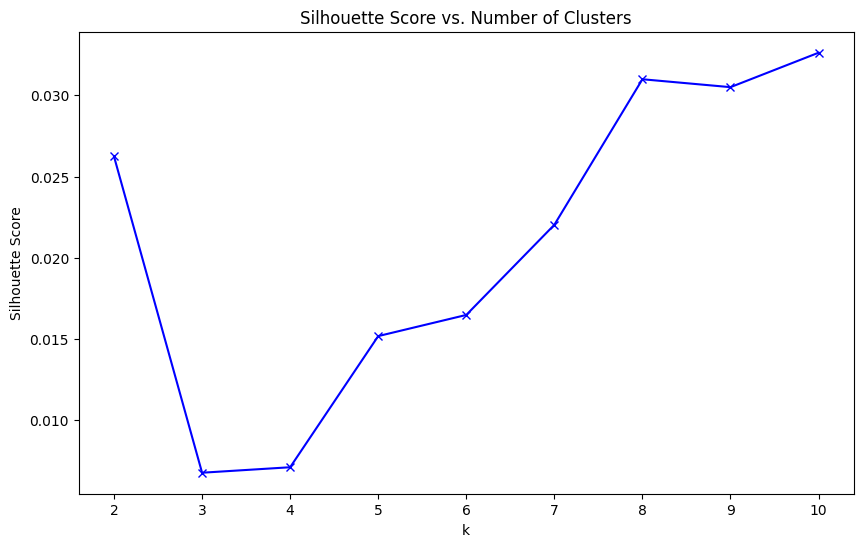

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, "bx-")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.show()

The silhouette score doesn't help much in determining the number of clusters to choose.
- Firstly, it is very low (between 0.01 and 0.03) for all tested k values.
- Secondly, the maximum seems to be reached for k=8, despite a slight peak at k=2, which follows the trend observed with the elbow method.

Since the silhouette score seems to extend beyond 10 clusters, we'll try to push it by calculating the silhouette score for k=2 to k=20. We started by looking at the results for a small number of clusters, as these are easier to visualize and interpret. However, it is possible that the silhouette score is higher for a higher number of clusters.


In [12]:
silhouette_scores = []
K = range(2, 20) # We'll still start at 2, but go up to 20 this time

In [13]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

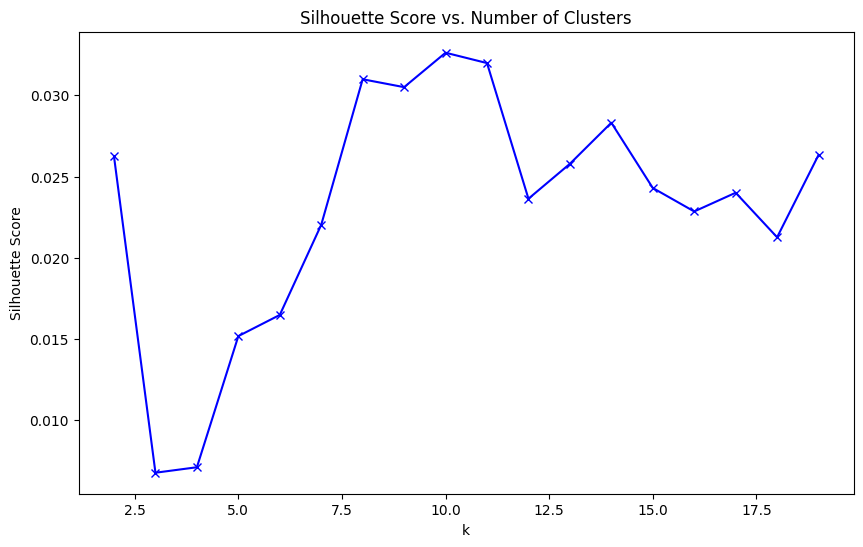

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, "bx-")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.show()

This curve is quite unusual!
- The range of values is still very low (between 0.01 and 0.03), indicating that the clusters are not very well separated, regardless of the number of clusters chosen;
- There is a lot of oscillation and instability in the curve, which is not typical for a silhouette score. Normally, we would expect a smoother curve;
- The peak at k=10 seems to be a local maximum, but the difference with other values is minimal...

These observations may suggest that the data is perhaps too noisy, or that the TF-IDF representation is not the most suitable for our dataset. It is also important to keep in mind that the dataset is quite small (only 1000 reviews), which can make the analysis more difficult.

But before giving up on using TfidfVectorizer, we'll still try to visualize the clusters for k=2 and k=8 to see if that helps us choose.

In [15]:
def analyze_clusters(k, tfidf_matrix, documents):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    cluster_sizes = []
    print(f"\nAnalyze for k={k} clusters:")
    
    for i in range(k):
        # Find documents in this cluster
        cluster_docs = [doc for doc, cluster in zip(documents, clusters) if cluster == i]
        cluster_sizes.append(len(cluster_docs))
        
        # Count the most frequent words
        all_words = [word for doc in cluster_docs for word in doc]
        word_freq = Counter(all_words)
        
        print(f"\nCluster {i}:")
        print(f"Nombre de documents: {len(cluster_docs)}")
        print("Top 10 mots les plus fréquents:")
        for word, freq in word_freq.most_common(10):
            print(f"{word}: {freq}")
            
    plt.figure(figsize=(10, 6))
    plt.bar(range(k), cluster_sizes)
    plt.xlabel("Cluster")
    plt.ylabel("Amount of documents")
    plt.title(f"Cluster sizes for k={k}")
    plt.show()

In [16]:
import numpy as np

In [17]:
def show_cluster_examples(k, tfidf_matrix, documents, n_examples=3):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    print(f"\nExamples for k={k} clusters:")
    for i in range(k):
        print(f"\nCluster {i}:")
        # Find documents in this cluster
        cluster_indices = [j for j, label in enumerate(clusters) if label == i]

        sample_indices = np.random.choice(cluster_indices, min(n_examples, len(cluster_indices)), replace=False)
        for idx, doc_idx in enumerate(sample_indices):
            print(f"Example {idx+1}: {' '.join(documents[doc_idx])}")


Analyze for k=2 clusters:

Cluster 0:
Nombre de documents: 733
Top 10 mots les plus fréquents:
phone: 727
case: 698
great: 284
good: 244
fit: 240
love: 210
screen: 183
like: 178
look: 160
nice: 146

Cluster 1:
Nombre de documents: 267
Top 10 mots les plus fréquents:
work: 281
charge: 206
great: 163
phone: 128
charger: 125
use: 89
review: 89
time: 87
cable: 78
like: 76


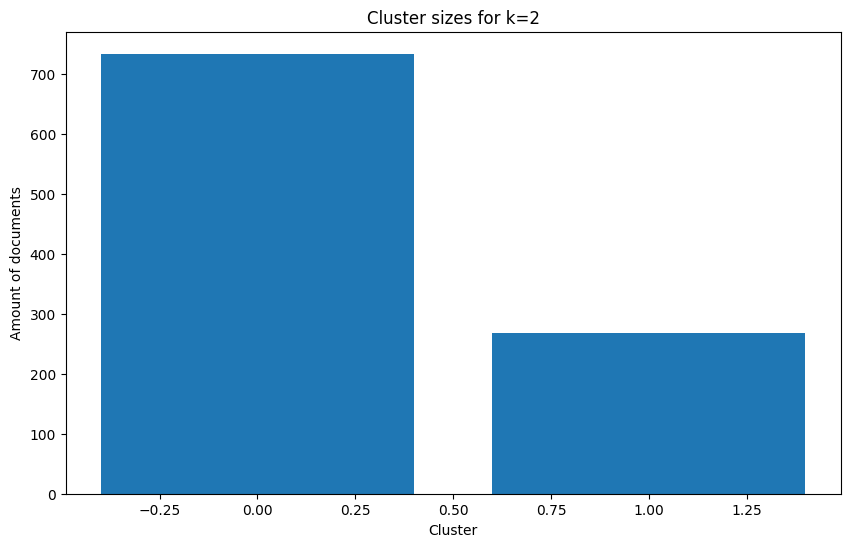

In [18]:
# Analyser pour k=2
analyze_clusters(2, tfidf_matrix, documents)

In [19]:
show_cluster_examples(2, tfidf_matrix, documents)


Examples for k=2 clusters:

Cluster 0:
Example 1: pop socket pull hard break
Example 2: protect screen iphone protect screen
Example 3: star nice looking

Cluster 1:
Example 1: interesting design sure point see day love neat tidy compact lot space easily slip pocket purse start play pull cable unevenly cause smoothly look product description online find pull time case smoothly floral image pretty rub multiple time wear far charge cable work comparable speed need find work iphone daughter fun stocking stuffer
Example 2: job work fine
Example 3: work perfect husband love work describe


As expected, the clusters are not very distinct. The most frequent words in each cluster are quite similar, and the sizes of the clusters are also quite close. However, we can still distinguish differences in themes between the clusters. The first one mentions "phone" and "case" where the second one seems to be more leaning towards chargers!


Analyze for k=8 clusters:

Cluster 0:
Nombre de documents: 429
Top 10 mots les plus fréquents:
phone: 264
screen: 141
like: 132
good: 124
fit: 122
love: 108
work: 104
great: 98
easy: 92
look: 80

Cluster 1:
Nombre de documents: 120
Top 10 mots les plus fréquents:
charge: 192
charger: 116
phone: 86
work: 84
cable: 68
time: 52
need: 47
good: 45
long: 44
usb: 44

Cluster 2:
Nombre de documents: 55
Top 10 mots les plus fréquents:
nice: 79
phone: 27
case: 20
look: 18
fit: 13
love: 11
like: 10
work: 10
use: 8
good: 8

Cluster 3:
Nombre de documents: 208
Top 10 mots les plus fréquents:
case: 579
phone: 416
great: 109
good: 93
fit: 90
love: 79
protect: 66
cover: 66
protection: 57
like: 54

Cluster 4:
Nombre de documents: 45
Top 10 mots les plus fréquents:
star: 52
phone: 13
great: 9
case: 8
love: 6
feel: 6
product: 6
nice: 6
color: 5
fit: 5

Cluster 5:
Nombre de documents: 5
Top 10 mots les plus fréquents:
edge: 15
case: 13
phone: 12
gold: 5
brown: 4
screen: 4
elago: 4
scratch: 4
leave: 4
fla

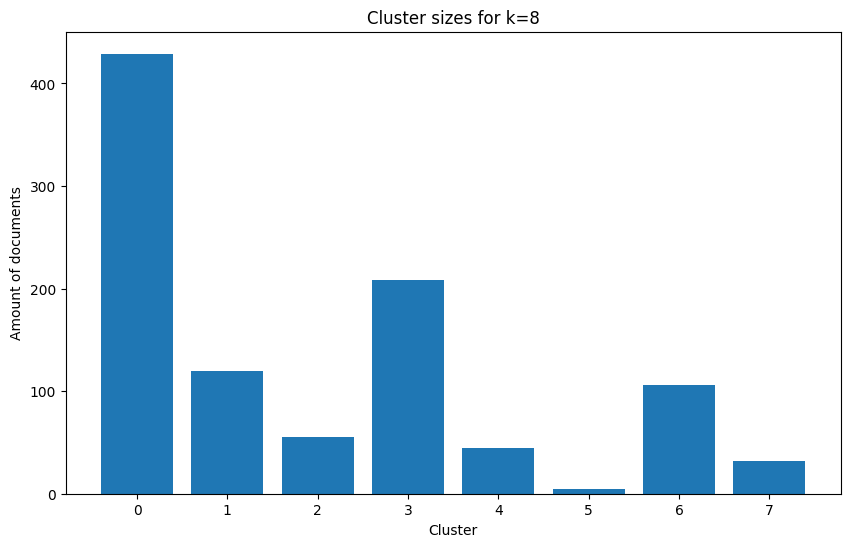

In [20]:
# Analyser pour k=8
analyze_clusters(8, tfidf_matrix, documents)

In [21]:
show_cluster_examples(8, tfidf_matrix, documents)


Examples for k=8 clusters:

Cluster 0:
Example 1: hook verizon set lockscreen image pop normal use hook verizon network will accept sim not lag issue run multiple app issue expect video run try good emergency temporary phone
Example 2: head plus sized gal pretty will able use awhile process try lose weight hour glass shape fit waist hip wear thing waist see hour glass shape people know short waiste wear thing waist attractive plus sized gal idea fit wear size fit waist perfectly hip sturdy fit samsung note fine key fob debit card driver licence fit couple month look plus sized think plus sized gal head
Example 3: good pretty good comfortable neck

Cluster 1:
Example 1: outlet usb power strip good look need outlet port usb charge port great addition room purchase guest room perfect size shape long wide electrical outlet usb port cover pop usb port use keep dust like power strip say hesitate update review new info useful
Example 2: charge multiple item probably large power bank see doub

This time, the results are more interesting. The clusters are much more distinct, but some are less significant than others.
- Cluster 0 focuses on the general user experience of the devices, in a rather positive way! we find keywords like "phone", "screen", "like", "good", ...
- Cluster 1, as for k=2, is more focused on the use of the charger: "charge", "cable", ...
- Cluster 3 concerns reviews on protections ("case") with positive words again ("great", "good", "fit") but in the last keywords, we also find "cover", "protection"... which confirms the theme!

The other clusters, smaller than those mentioned above (with between 5 and 55 documents compared to 106 to 429 for the 3 large clusters), are more difficult to interpret. This may be due to the noisy nature of the data, or to the difficulty of finding clear themes in consumer reviews.

After a more or less fruitful use of KMeans, it may be interesting to try an approach with DBScan. This method is more suitable for clusters of arbitrary shapes, and can be more robust to noise. However, it is more sensitive to hyperparameters, and can be more difficult to interpret. So we will try to apply DBScan to our data to see if it gives better results.

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [23]:
# Scale the data before applying DBScan
tfidf_dense = tfidf_matrix.toarray()
scaler = StandardScaler(with_mean=False)
tfidf_scaled = scaler.fit_transform(tfidf_dense)

In [24]:
def analyze_dbscan_clusters(labels, documents):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"Amount of found clusters: {n_clusters}")
    print(f"Amount of points considered as noise: {n_noise}")
    
    # Analyze each cluster
    for i in range(-1, max(labels) + 1):  # -1 is for noise
        cluster_docs = [doc for doc, cluster in zip(documents, labels) if cluster == i]
        
        if i == -1:
            print(f"\nNoise:")
        else:
            print(f"\nCluster {i}:")
            
        print(f"Amount of documents: {len(cluster_docs)}")
        
        if len(cluster_docs) > 0:
            # Count the most frequent words
            all_words = [word for doc in cluster_docs for word in doc]
            word_freq = Counter(all_words)
            print("Top 10 mots les plus fréquents:")
            for word, freq in word_freq.most_common(10):
                print(f"{word}: {freq}")

In [25]:
eps_values = [0.1, 0.3, 0.5, 0.7, 1.0]
min_samples_values = [2, 3, 5, 10]

In [26]:
for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\nDBScan with eps={eps}, min_samples={min_samples}")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(tfidf_scaled)
        analyze_dbscan_clusters(labels, documents)


DBScan with eps=0.1, min_samples=2
Amount of found clusters: 9
Amount of points considered as noise: 975

Noise:
Amount of documents: 975
Top 10 mots les plus fréquents:
phone: 855
case: 727
great: 437
work: 344
good: 312
fit: 260
like: 254
love: 251
charge: 227
screen: 204

Cluster 0:
Amount of documents: 4
Top 10 mots les plus fréquents:
star: 4
crap: 1
garbage: 1
dollar: 1
store: 1
strictly: 1
fantastic: 1

Cluster 1:
Amount of documents: 2
Top 10 mots les plus fréquents:
case: 2
love: 2
sparkle: 1
yes: 1

Cluster 2:
Amount of documents: 2
Top 10 mots les plus fréquents:
star: 2
love: 2
compartment: 1

Cluster 3:
Amount of documents: 3
Top 10 mots les plus fréquents:
great: 3
versatility: 2
satisfied: 1
customer: 1
handy: 1
emergency: 1

Cluster 4:
Amount of documents: 4
Top 10 mots les plus fréquents:
junk: 2
stylus: 1
pen: 1
bring: 1
mistake: 1
wrong: 1
convenient: 1
reliable: 1
ask: 1

Cluster 5:
Amount of documents: 2
Top 10 mots les plus fréquents:
look: 3
decent: 1
cool: 1
ca

DBScan results aren't very conclusive either. The found clusters are very small, and most points are considered noise. This may be due to the relatively low density of the data, or to the difficulty of finding significant clusters in consumer reviews.